In [0]:
from fastai.vision import *

**Getting a list of URLs of our images**

Goto Google Image search and click on ctrl+shift+j and execute this js code to extract the URLs "urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));"

In [0]:
folder = 'black'
file = 'urls_black.csv'
path = Path('data/bears')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [3]:
path.ls()

[PosixPath('data/bears/black')]

In [0]:
folder = 'teddys'
file = 'urls_teddys.csv'
path = Path('data/bears')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [0]:
folder = 'grizzly'
file = 'urls_grizzly.csv'
path = Path('data/bears')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [6]:
path.ls()

[PosixPath('data/bears/black'),
 PosixPath('data/bears/grizzly'),
 PosixPath('data/bears/teddys')]

**Download images**

In [0]:
classes = ['teddys','grizzly','black']

In [0]:
download_images('download', 'data/bears/teddys', max_pics=200)

In [10]:
download_images('download (1)', 'data/bears/grizzly', max_pics=200)

In [11]:
download_images('download (2)', 'data/bears/black', max_pics=200)

**Remove image that cannot be opened**

In [12]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

teddys


grizzly


black


**View the data**

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [14]:
data.classes

['black', 'grizzly', 'teddys']

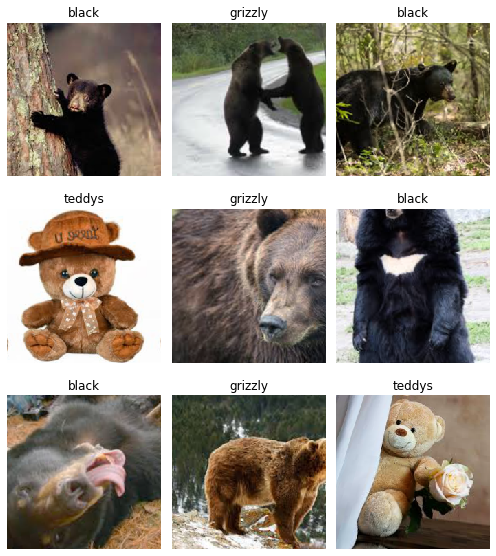

In [15]:
data.show_batch(rows=3, figsize=(7,8))

In [16]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black', 'grizzly', 'teddys'], 3, 240, 60)

**Learn the model**

In [17]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [18]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.400106,0.151375,0.083333,00:04
1,0.834685,0.068754,0.016667,00:03
2,0.586104,0.101215,0.016667,00:03
3,0.446265,0.109562,0.016667,00:03


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


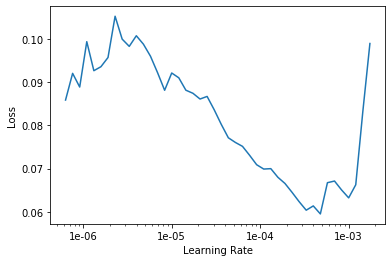

In [22]:
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.077900,0.085889,0.016667,00:03
1,0.060373,0.092276,0.016667,00:03


In [0]:
learn.save('stage-2')

**Interpretation**

In [0]:
learn.load('stage-2');

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

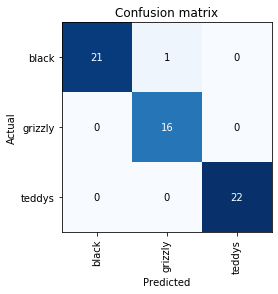

In [27]:
interp.plot_confusion_matrix()

**Cleaning the data which is not related**

In [0]:
from fastai.widgets import *

In [0]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [0]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [31]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

**Putting your model in production**
This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

In [0]:
learn.export()

In [0]:
defaults.device = torch.device('cpu')

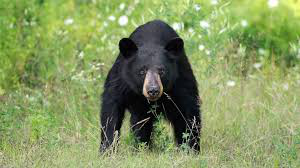

In [34]:
img = open_image(path/'black'/'00000021.jpg')
img

**We create our Learner in production enviromnent like this**

In [0]:
path = 'data/bears'
learn = load_learner(path)

In [40]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category black

In [41]:
pred_idx

tensor(0)

In [42]:
outputs

tensor([1.0000e+00, 4.2927e-07, 8.8188e-09])

**Scenarios where things can go wrong**

Learning rate is too high

In [43]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(1, max_lr=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,6.671978,3414676736.000000,0.733333,00:03


Learning rate is too low

In [44]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(5, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,2.079498,2.484103,0.750000,00:03
1,1.815696,1.712057,0.700000,00:03
2,1.827489,1.344997,0.666667,00:03
3,1.766763,1.177461,0.533333,00:03
4,1.758620,1.130142,0.533333,00:03


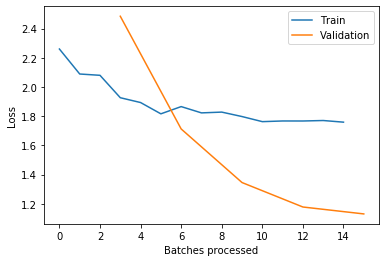

In [45]:
learn.recorder.plot_losses()

Too few epochs

In [46]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,2.013234,83.560448,0.633333,00:03


Too many epochs

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=16, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [49]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()
learn.fit_one_cycle(40, slice(1e-6,1e-4))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.305745,1.931663,0.766667,00:03
1,1.328931,1.841288,0.759259,00:02
2,1.404299,1.678820,0.748148,00:02
3,1.456280,1.522115,0.666667,00:02
4,1.445871,1.354659,0.637037,00:02
5,1.422018,1.206295,0.577778,00:02
6,1.285765,1.041386,0.481481,00:02
7,1.173222,0.880524,0.377778,00:02
8,1.072491,0.729320,0.311111,00:02
9,0.966153,0.616351,0.266667,00:02
